# Web scraping project - First scraping notebook
### **Léo RINGEISSEN & Santiago MARTIN - DIA 3**

## API call example

With this code, we perform an API call to the website that's linked in our Project Plan pdf document. With this, we demonstrate the type of information we seek to retrieve about travel itineraries of the SNCF : 
- origin and destination (names and IDs)
- transporter (type of train)
- distance between stations (Km)
- carbon emissions of different methods of transport (train, bus, plane, electric and normal cars)

In [11]:
import requests

# Define the API URL
url = "https://ressources.data.sncf.com/api/records/1.0/search/"

# Define the parameters
params = {
    "dataset": "emission-co2-perimetre-complet",  # Ensure dataset is specified
    "q": "",  # Empty query to fetch all records
    "rows": 100,  # Adjust the number of records as needed
    "select": "origine, destination, transporteur, distance_entre_les_gares, "
              "train_empreinte_carbone_kgco2e, autocar_longue_distance_empreinte_carbone_kgco2e, avion_empreinte_carbone_kgco2e, "
              "voiture_electrique_2_2_pers_empreinte_carbone_kgco2e, voiture_thermique_2_2_pers_empreinte_carbone_kgco2e",  # Select relevant fields
}

# Make the API request
response = requests.get(url, params=params)

# Check the response status
if response.status_code == 200:
    data = response.json()  # Parse the JSON response
    # Print or process the records
    if "records" in data and data["records"]:
        for record in data["records"]:
            print(record.get("fields", {}))
    else:
        print("No records found.")
else:
    print(f"Error: {response.status_code} - {response.text}")


{'destination_uic': '87746008', 'distance_entre_les_gares': 545.0, 'transporteur': 'TGV', 'origine': 'Paris Gare de Lyon', 'train_empreinte_carbone_kgco2e': 1.5805, 'origine_uic': '87686006', 'destination': 'Annecy', 'autocar_longue_distance_empreinte_carbone_kgco2e': 19.32, 'voiture_electrique_2_2_pers_empreinte_carbone_kgco2e': 26.32, 'voiture_thermique_2_2_pers_empreinte_carbone_kgco2e': 60.368}
{'destination_uic': '87474007', 'distance_entre_les_gares': 249.0, 'transporteur': 'TER', 'origine': 'Rennes', 'train_empreinte_carbone_kgco2e': 6.0756, 'origine_uic': '87471003', 'destination': 'Brest', 'autocar_longue_distance_empreinte_carbone_kgco2e': 8.418, 'voiture_electrique_2_2_pers_empreinte_carbone_kgco2e': 11.468, 'voiture_thermique_2_2_pers_empreinte_carbone_kgco2e': 26.3032}
{'destination_uic': '85030007', 'distance_entre_les_gares': 614.0, 'avion_empreinte_carbone_kgco2e': 70.36030000000001, 'transporteur': 'International', 'origine': 'Paris Gare de Lyon', 'train_empreinte_carb

## Web scraping page example

For the web scraping part, we decided to scrape user reviews on Tripadvisor. We chose the city of Marseille for our first test.
We used the selenium-enabled chrome webdriver for this task.

The results are then extracted into a csv file. The first tests are conclusive, with just a few formatting issues left to resolve for the date, and some symbols appearing.

Netx objective will be to find a way to extract more reviews at once, since they are displayed five by five. 

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from bs4 import BeautifulSoup
import pandas as pd
import requests
import re



# Mettre à jour le chemin vers votre ChromeDriver
driver_path = 'C:/Users/ringi_3xz04z7/Downloads/chromedriver-win64/chromedriver-win64/chromedriver.exe'

# Configuration du Service WebDriver
service = Service(driver_path)
driver = webdriver.Chrome(service=service)

# URL de la page TripAdvisor
url = 'https://www.tripadvisor.fr/ShowUserReviews-g187253-r282071566-Marseille_Bouches_du_Rhone_Provence_Alpes_Cote_d_Azur.html#REVIEWS'

# En-têtes pour imiter un navigateur
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:104.0) Gecko/20100101 Firefox/104.0',
    'Accept-Language': 'fr-FR,fr;q=0.9',
    'Referer': 'https://www.google.com',
    'Connection': 'keep-alive'
}

# Def pour transformer la note sur 5
def convert_bubble_to_rating(bubble_class):
    # Extraire le nombre de la classe bubble_XX
    if 'bubble_' in bubble_class:
        bubble_value = int(bubble_class.split('_')[1])
        # Convertir en note sur 5
        print(bubble_value)
        return bubble_value // 10  # Ex: bubble_50 -> 5, bubble_40 -> 4
    return None

# Récupérer la page
response = requests.get(url, headers=headers)

if response.status_code == 200:
    # Parser le contenu HTML
    soup = BeautifulSoup(response.text, 'html.parser')

    # Extraire les reviews en fonction de l'id
    review_blocks = soup.find_all('div', id=re.compile(r'review_\d+'))

    reviews = []

    for block in review_blocks:
        # Extraire le titre
        title = block.find('div', class_='quote').get_text(strip=True) if block.find('div', class_='quote') else None
        
        # Extraire le contenu dans la div avec class 'entry'
        content = block.find('div', class_='entry').get_text(strip=True) if block.find('div', class_='entry') else None
        
        # Extraire la note
        rating_element = block.find('span', class_='ui_bubble_rating')
        
        # Transformer la note
        rating = convert_bubble_to_rating(rating_element['class'][1]) if rating_element else None
        
        # Extraire la date
        date = block.find('span', class_='ratingDate').get_text(strip=True) if block.find('span', class_='ratingDate') else None

        # Ajouter la review à la liste
        reviews.append({
            'Title': title,
            'Content': content,
            'Rating': rating,
            'Date': date
        })

    # Sauvegarder dans un DataFrame et l'exporter vers un CSV
    df = pd.DataFrame(reviews)
    df.to_csv('tripadvisor_reviews.csv', index=False,sep=';')
    print("Extraction terminée ! Données sauvegardées dans 'tripadvisor_reviews.csv'.")
else:
    print(f"Échec de la récupération de la page. Code de statut : {response.status_code}")


50
30
50
40
40
Extraction terminée ! Données sauvegardées dans 'tripadvisor_reviews.csv'.


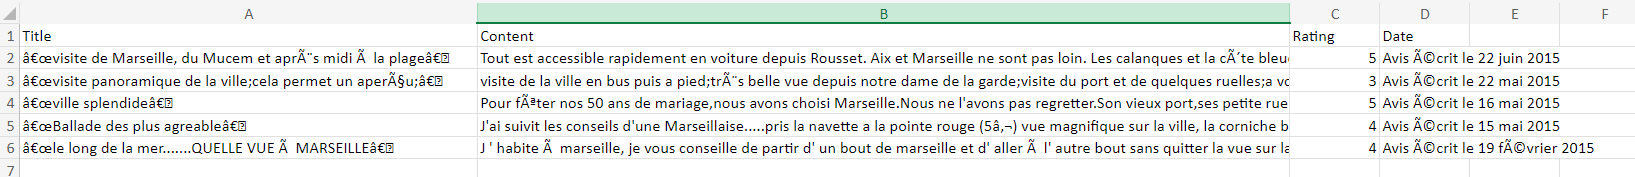
